In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
#import datasets
import numpy as np

pl.seed_everything(89026614)

#text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614


In [5]:
device = "mps"
block_size = 512
test_size = 1500
batch_size = 36

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [6]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=60, num_layers=5):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )

    def forward(self, x):
        B, T, C = x.shape
        x = x + F.tanh(self.q(x)) * F.pad(x[:, :T-1, :], (0, 0, 1, 0))
        x = x + self.mlp(x)
        return x

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long).unsqueeze(0).to(self.device)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=60, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 174 K 
-------------------------------
174 K     Trainable params
0         Non-trainable params
174 K     Total params
0.696     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 209/209 [00:09<00:00, 22.00it/s, loss=1.48, v_num=166]And now. "But I am to his police streass.

"Nose back."

I'll fine." An
Epoch 4: 100%|██████████| 209/209 [00:16<00:00, 12.84it/s, loss=1.32, v_num=166, test_loss=1.330]And now."

"Oh, I won't know. Bobbsey. "Tell he seemed them for her wav
Epoch 6: 100%|██████████| 209/209 [00:13<00:00, 15.10it/s, loss=1.29, v_num=166, test_loss=1.280]And now?"







Platve us, and put fals and saw a wife take the first 
Epoch 12: 100%|██████████| 209/209 [00:12<00:00, 16.27it/s, loss=1.25, v_num=166, test_loss=1.250]And now of meat house, and all him, but that move of the rror.

The ten
Epoch 19: 100%|██████████| 209/209 [00:12<00:00, 16.14it/s, loss=1.22, v_num=166, test_loss=1.250]And now the placed him to see Martin. "I wish to the parrot before.

"I
Epoch 20: 100%|██████████| 209/209 [00:12<00:00, 16.19it/s, loss=1.22, v_num=166, test_loss=1.230]And now!" answered."

"So as well on the blew was a tiger. She had been


`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 209/209 [00:13<00:00, 15.06it/s, loss=1.15, v_num=166, test_loss=1.160]


Epoch 5:  81%|████████▏ | 170/209 [13:51<03:10,  4.89s/it, loss=1.29, v_num=165, test_loss=1.310]


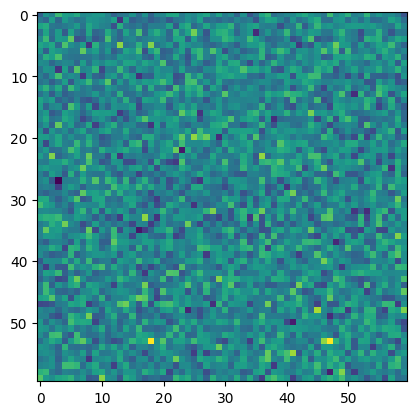

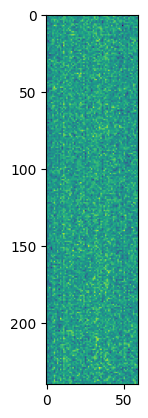

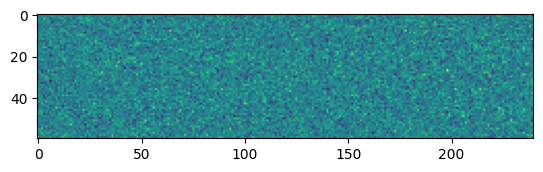

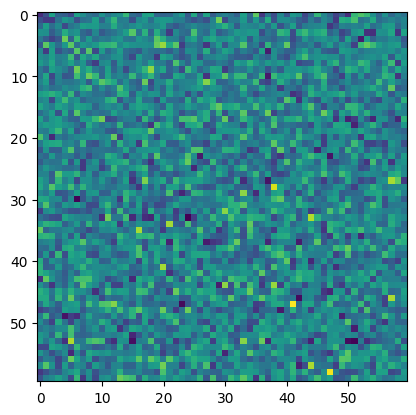

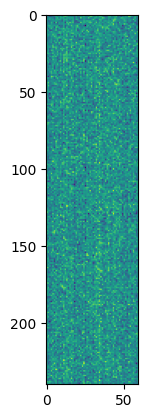

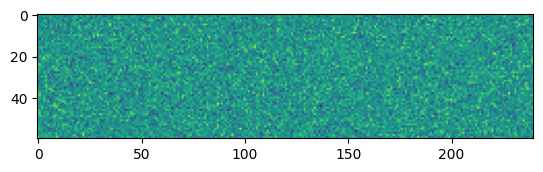

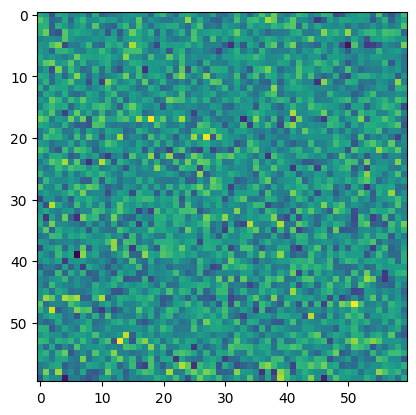

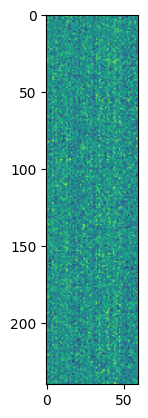

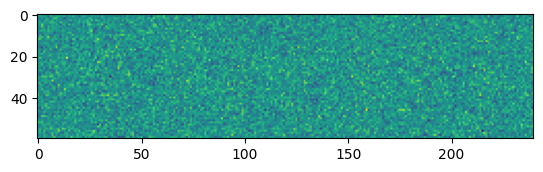

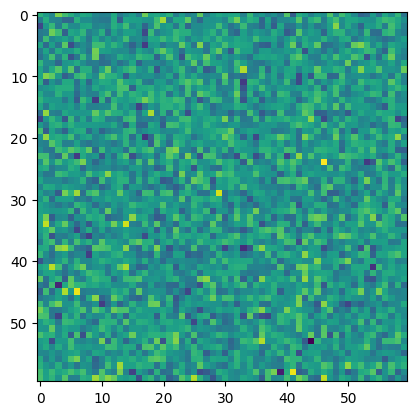

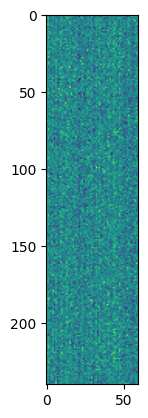

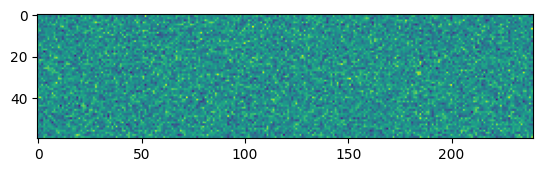

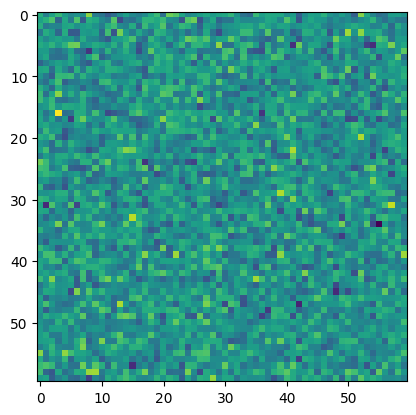

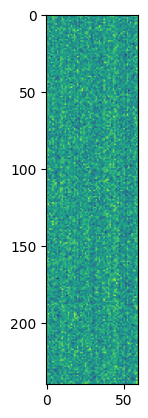

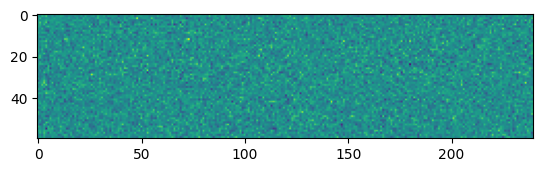

In [7]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.q.weight.detach())
    plt.figure()
    plt.imshow(b.mlp[0].weight.detach())
    plt.figure()
    plt.imshow(b.mlp[2].weight.detach())

In [8]:
print(model.generate("O God, O God!", 650))

O God, O God! I guess it," agreed Sue, when they came down in the rail stand the back of the wanted the work a briar, but shell went them to be gone with my friends of peace to the herself." And we do all right and beauty open been off through and break. After him, as the road in it to get them and make him till soon. And when the front, too!" cried Uncle Wiggily had no more that has a bear is sat by the closely of a mittens to say the wrist she was a circle as he has clashing family, as he was talking for the sol-dier and see a day by the tide. "Where it to brushed tried the little sisters throom old grapes on their fun after you."

"Well, if there will 
